In [1]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


In [2]:
import numpy as np

## TORCH IMPORTS ##
import torch
import torch.nn as nn
from torch.autograd import Variable

import sys
import platform
import matplotlib.pyplot as plt

from numpy.fft import fft, ifft,fft2, ifft2, fftn, ifftn
from scipy import signal
import os
import scipy
import time

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if torch.backends.mps.is_built() \
    else "cuda:0" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")

# print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: Windows-11-10.0.26100-SP0
PyTorch Version: 2.6.0+cu124
GPU is available
MPS (Apple Metal) is NOT AVAILABLE
Target device is cuda:0


In [3]:
class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)
    
class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()
   

        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(Sin())
                # layers.append(torch.sin(layers))
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(Sin())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))

        self.linear = nn.Sequential(*layers)

    def forward(self, x, y, t):
        src = torch.cat((x, y, t), dim=-1)
        return self.linear(src)
    

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [4]:
net = PINNs(in_dim=3, hidden_dim=32, out_dim=4, num_layer=3).to(device) #Input dimensions increased from 2 to 3 and Output dimensions from 3 to 4 to account for the increased spatial dimension (y)
net.apply(init_weights)
print(net) 
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr=0.001,)
optimizerL = torch.optim.LBFGS(net.parameters(),line_search_fn='strong_wolfe')

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Sin()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Sin()
    (4): Linear(in_features=32, out_features=4, bias=True)
  )
)


In [5]:
def get_boundary_rho_vel_phi(x_bc_l, x_bc_r, y_bc_l, y_bc_r, t, net):

    rho_l, vel_l_x, vel_l_y, phi_l = net(x_bc_l,y_bc_l,t)[:,0:1], net(x_bc_l,y_bc_l,t)[:,1:2], net(x_bc_l,y_bc_l,t)[:,2:3], net(x_bc_l,y_bc_l,t)[:,3:4]
    rho_r, vel_r_x, vel_r_y, phi_r = net(x_bc_r,y_bc_r,t)[:,0:1], net(x_bc_r,y_bc_r,t)[:,1:2], net(x_bc_r,y_bc_r,t)[:,2:3], net(x_bc_r,y_bc_r,t)[:,3:4]

    '''
    vel_l_x is the x-component of velocity at the left boundary
    vel_l_y is the y-component of velocity at the left boundary
    vel_r_x is the x-component of velocity at the right boundary
    vel_r_y is the y-component of velocity at the right boundary
    these codes are generated in the same way as rho_l, vel_l, phi_l = net(x_bc_l,t)[:,0:1], net(x_bc_l,t)[:,1:2], net(x_bc_l,t)[:,2:3] &
    rho_r, vel_r, phi_r = net(x_bc_r,t)[:,0:1], net(x_bc_r,t)[:,1:2], net(x_bc_r,t)[:,2:3]

    '''

    phi_l_x = torch.autograd.grad(phi_l, x_bc_l, grad_outputs=torch.ones_like(phi_l), create_graph=True)[0]
    phi_r_x = torch.autograd.grad(phi_r, x_bc_r, grad_outputs=torch.ones_like(phi_r), create_graph=True)[0]

    phi_l_y = torch.autograd.grad(phi_l, y_bc_l, grad_outputs=torch.ones_like(phi_l), create_graph=True)[0]
    phi_r_y = torch.autograd.grad(phi_r, y_bc_r, grad_outputs=torch.ones_like(phi_r), create_graph=True)[0]

    #phi_l_y is the y axis equivalent of phi_l_x
    #phi_r_y is the y axis equivalent of phi_r_x

    rho_b_x = rho_l - rho_r 
    rho_b_y = rho_l - rho_r        #The loss function of rho_b_x and rho_b_y are defined in the same way as (1/Nb)*Σ|ρθ(ti, xi, yi) - ρb(ti, xi, yi)|^2
    vel_b_x_x = vel_l_x - vel_r_x  #The Lvxbx term (I assume it as the loss between the x velocities of the left and right boundaries)
    vel_b_x_y = vel_l_x - vel_l_y  #The Lvxby term (I assume it as the loss between the x and y velocity of the left boundary)
    vel_b_y_x = vel_r_y - vel_r_x  #The Lvybx term (I assume it as the loss between the y and x velocity of the right boundary)
    vel_b_y_y = vel_l_y - vel_r_y  #The Lvyby term (I assume it as the loss between the y velocities of the left and right boundaries)
    phi_b_x = phi_l - phi_r
    phi_b_y = phi_l = phi_r        #The loss function of phi_b_x and phi_b_y are defined in the same way as (1/Nb)*Σ|φθ(ti, xi, yi) - φb(ti, xi, yi)|^2
    phi_x_x_b = phi_l_x - phi_r_x  
    phi_y_y_b = phi_l_y - phi_r_y  #Losses associated with dφ in x and y directions

    return rho_b_x, rho_b_y, vel_b_x_x, vel_b_x_y, vel_b_y_x, vel_b_y_y, phi_b_x , phi_b_y, phi_x_x_b, phi_y_y_b

def pde_residue(x, y, t, net):

    net_outputs = net(x,y,t)
    
    rho, v_x, v_y, phi = net_outputs[:,0:1], net_outputs[:,1:2], net_outputs[:,2:3], net_outputs[:,3:4]

    rho_x = torch.autograd.grad(rho, x,grad_outputs=torch.ones_like(rho), create_graph=True)[0]
    rho_y = torch.autograd.grad(rho, y,grad_outputs=torch.ones_like(rho), create_graph=True)[0]
    rho_t = torch.autograd.grad(rho, t,grad_outputs=torch.ones_like(rho),create_graph=True)[0]

    v_x_x = torch.autograd.grad(v_x, x,grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_x_y = torch.autograd.grad(v_x, y,grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y_x = torch.autograd.grad(v_y, x,grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    v_y_y = torch.autograd.grad(v_y, y,grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
    
    v_x_t = torch.autograd.grad(v_x, t,grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
    v_y_t = torch.autograd.grad(v_y, t,grad_outputs=torch.ones_like(v_y), create_graph=True)[0]

    phi_x = torch.autograd.grad(phi, x,grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_x_x = torch.autograd.grad(phi_x, x,grad_outputs=torch.ones_like(phi_x), create_graph=True)[0]

    phi_y = torch.autograd.grad(phi, y,grad_outputs=torch.ones_like(phi), create_graph=True)[0]
    phi_y_y = torch.autograd.grad(phi_y, y,grad_outputs=torch.ones_like(phi_y), create_graph=True)[0]

    rho_r = rho_t + v_x * rho_x + rho * v_x_x + v_y * rho_y + rho * v_y_y #The residue from the density equation, in the same format as in PINN-2DG
    v_x_r = rho * v_x_t + rho * (v_x * v_x_x + v_y * v_x_y) + cs * cs * rho_x + rho * phi_x #The momentum equation in 2D in X, in the same format as in PINN-2DG
    v_y_r = rho * v_y_t + rho * (v_y * v_y_y + v_x * v_y_x) + cs * cs * rho_y + rho * phi_y #The momentum equation in 2D in Y, in the same format as in PINN-2DG
    phi_r = phi_x_x + phi_y_y - const * (rho - rho_o) #The residue from the Poisson equation, in the same format as in PINN-2DG

    return rho_r, v_x_r, v_y_r, phi_r

In [6]:
## CASE 1           (refer to the paper for details)
lam = 7.0           # one wavelength
num_of_waves = 2
rho_1 = 0.03        # question 2a linear wave propagation

# ## CASE 2          (refer to the paper for details)
# lam = 7.0          # one wavelength
# num_of_waves = 3
# rho_1 = 0.3        # question 2a linear wave propagation

# ## CASE 2          (refer to the paper for details)
# lam = 5.0          # one wavelength
# num_of_waves = 3
# rho_1 = 0.03       # question 2a linear wave propagation

In [7]:
rho_o = 1          ## zeroth order density
cs = 1.0           ##  Sound Speed
const = 1          ## we set 4 pi G  to 1
G = 1

output_folder = "2D_fig" 
os.makedirs(output_folder, exist_ok=True)

jeans = np.sqrt(4*np.pi**2*cs**2/(const*G*rho_o))

if lam> jeans:
    alpha = np.sqrt(const*G*rho_o-cs**2*(2*np.pi/lam)**2)
else:
    alpha = np.sqrt(cs**2*(2*np.pi/lam)**2 - const*G*rho_o)
    
# v_1 = (cs*rho_1)/rho_o                     ## velocity perturbation without gravity
v_1  = (rho_1/rho_o) * (alpha/(2*np.pi/lam)) ## With gravity


def fun_rho_0(x):
    ''' Define initial condition for density Returning Eq (11a)'''
    print('wavelength',lam)
    rho_0 = rho_o + rho_1 * np.cos(2*np.pi*x/lam)    
    return rho_0

def fun_v_0(x):
    '''initial condition for velocity -- Returning Eq 11b'''
    
    if lam > jeans:
        v_0 = - v_1 * np.sin(2*np.pi*x/lam)## This is for sound wave ## refer to the paper for details
    else:
        v_0 = v_1 * np.cos(2*np.pi*x/lam)  ## This is for the gravity wave
    return v_0

In [8]:
tmin = 0.
tmax = 1.

xmin = 0.
xmax = xmin+lam*num_of_waves

ymin = 0
ymax = ymin+lam*num_of_waves

cs = 1.

### NUMBER OF COLLOCATION POINTS ##

N_0 = 10000   ## for IC
N_b = 10000   ## for BC
N_r = 30000  ## for Domain



############## IC setup ################

# Intial conditions collocation points
x_0 = np.random.uniform(low=xmin, high=xmax, size=(N_0,1))
y_0 = np.random.uniform(low=xmin, high=xmax, size=(N_0,1))
t_0 = np.zeros((N_0,1))

# Evaluate intitial condition at x_0
rho_0 = fun_rho_0(x_0)
v_0 = fun_v_0(x_0)

#IC torch variable
pt_x_0 = Variable(torch.from_numpy(x_0).float(), requires_grad=False).to(device)
pt_y_0 = Variable(torch.from_numpy(y_0).float(), requires_grad=False).to(device) #Initial conditions for y direction
pt_t_0 = Variable(torch.from_numpy(t_0).float(), requires_grad=False).to(device)
pt_rho_0 = Variable(torch.from_numpy(rho_0).float(), requires_grad=False).to(device)
pt_vel_0 = Variable(torch.from_numpy(v_0).float(), requires_grad=False).to(device)

# ## Checking the initial profiles
# plt.scatter(x_0, rho_0,s=20, c='b', marker='o',label="Ini-Density")
# plt.scatter(x_0, v_0,s=2, c='r', marker='*',label="Ini-Velocity" )
# plt.legend()



############## BC setup ################

x_bc_l = np.empty(N_b); x_bc_l.fill(xmin)
x_bc_r = np.empty(N_b); x_bc_r.fill(xmax)
y_bc_l = np.empty(N_b); y_bc_l.fill(ymin) #for y direction in left boundary
y_bc_r = np.empty(N_b); y_bc_r.fill(ymax) #for y direction in right boundary
t_bc = np.random.uniform(low=tmin, high=tmax, size=(N_b,1))
#BC torch variable
pt_x_bc_l = Variable(torch.from_numpy(x_bc_l.reshape(N_b,1)).float(), requires_grad=True).to(device)
pt_x_bc_r = Variable(torch.from_numpy(x_bc_r.reshape(N_b,1)).float(), requires_grad=True).to(device)
pt_y_bc_l = Variable(torch.from_numpy(y_bc_l.reshape(N_b,1)).float(), requires_grad=True).to(device) #for y direction in left boundary
pt_y_bc_r = Variable(torch.from_numpy(y_bc_r.reshape(N_b,1)).float(), requires_grad=True).to(device) #for y direction in right boundary
pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)


############## PDE setup ################


x_collocation = np.random.uniform(low=xmin, high=xmax, size=(N_r,1))
y_collocation = np.random.uniform(low=ymin, high=ymax, size=(N_r,1)) #for y direction
t_collocation = np.random.uniform(low=tmin, high=tmax, size=(N_r,1))

#as torch variable
pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
pt_y_collocation = Variable(torch.from_numpy(y_collocation).float(), requires_grad=True).to(device) #for y direction
pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
print(np.shape(pt_x_collocation), np.shape(pt_y_collocation))

wavelength 7.0
torch.Size([30000, 1]) torch.Size([30000, 1])


In [9]:
from tqdm import tqdm
import time
iterations = 200
start = time.time()
def closure():

        ############## Loss based on initial conditions ###############

        net_ic_out = net(pt_x_0, pt_y_0, pt_t_0) # output of rho(x,t=0), vel(x,t=0)

        rho_ic_out = net_ic_out[:,0:1]
        vel_x_ic_out = net_ic_out[:,1:2]
        vel_y_ic_out = net_ic_out[:, 2:3]

        mse_rho_ic =  mse_cost_function(rho_ic_out, pt_rho_0)
        mse_vel_x_ic =  mse_cost_function(vel_x_ic_out, pt_vel_0)
        mse_vel_y_ic =  mse_cost_function(vel_y_ic_out, pt_vel_0)

        ############# Loss based on boundary conditions #################

        (
            rho_b_x, rho_b_y,
            vel_b_x_x, vel_b_x_y,
            vel_b_y_x, vel_b_y_y,
            phi_b_x, phi_b_y,
            phi_x_x_b, phi_y_y_b
        ) = get_boundary_rho_vel_phi(pt_x_bc_l, pt_x_bc_r, pt_y_bc_l, pt_y_bc_r, pt_t_bc, net)


        mse_bc_rho_x = torch.mean(rho_b_x ** 2)
        mse_bc_rho_y = torch.mean(rho_b_y ** 2)
        mse_bc_vel_x_x = torch.mean(vel_b_x_x ** 2)
        mse_bc_vel_x_y = torch.mean(vel_b_x_y ** 2)
        mse_bc_vel_y_x = torch.mean(vel_b_y_x ** 2)
        mse_bc_vel_y_y = torch.mean(vel_b_y_y ** 2)
        mse_bc_phi_x = torch.mean(phi_b_x ** 2)
        mse_bc_phi_y = torch.mean(phi_b_y ** 2)
        mse_bc_phi_x_x = torch.mean(phi_x_x_b ** 2)
        mse_bc_phi_y_y = torch.mean(phi_y_y_b ** 2)

        ############## Loss based on PDE ###################################

        rho_r, v_x_r, v_y_r, phi_r = pde_residue(pt_x_collocation, pt_y_collocation, pt_t_collocation, net) # output of rho(x,t) and vel(x,t)


        mse_rho = torch.mean(rho_r ** 2) 
        mse_vel_x = torch.mean(v_x_r ** 2)
        mse_vel_y = torch.mean(v_y_r ** 2)
        mse_phi = torch.mean(phi_r ** 2)

        ################### Combining the loss functions ####################
        loss = (
            mse_rho_ic + mse_vel_x_ic + mse_vel_y_ic +  # Initial conditions
            mse_rho + mse_vel_x + mse_vel_y + mse_phi +  # PDE residuals
            mse_bc_rho_x + mse_bc_rho_y +               # Boundary: rho
            mse_bc_vel_x_x + mse_bc_vel_x_y +           # Boundary: vel_x
            mse_bc_vel_y_x + mse_bc_vel_y_y +           # Boundary: vel_y
            mse_bc_phi_x + mse_bc_phi_y +               # Boundary: phi gradients
            mse_bc_phi_x_x + mse_bc_phi_y_y             # Boundary: phi 2nd derivatives
        )
        optimizerL.zero_grad()
        loss.backward() # This is for computing gradients using backward propagationerivative of J w.r.t theta
        return loss
TOTAL_loss = []

## Using ADAM 

for i in tqdm(range(iterations)): 
    loss_ = optimizer.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
print("INFO:Adam training done LBFGS initiated")       
## Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations)): 
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  0%|          | 0/200 [00:00<?, ?it/s]

  1%|          | 2/200 [00:01<01:53,  1.75it/s]

TOTAL LOSS =6.57e+00


 27%|██▋       | 54/200 [00:05<00:09, 14.86it/s]

TOTAL LOSS =2.75e-01


 52%|█████▏    | 104/200 [00:08<00:06, 15.25it/s]

TOTAL LOSS =1.01e-01


 77%|███████▋  | 154/200 [00:11<00:02, 15.41it/s]

TOTAL LOSS =5.73e-02


100%|██████████| 200/200 [00:14<00:00, 13.39it/s]


INFO:Adam training done LBFGS initiated


  0%|          | 1/200 [00:01<05:38,  1.70s/it]

TOTAL LOSS =3.85e-02


 26%|██▌       | 51/200 [01:35<04:53,  1.97s/it]

TOTAL LOSS =2.79e-05


 50%|█████     | 101/200 [03:13<03:05,  1.88s/it]

TOTAL LOSS =6.62e-06


 76%|███████▌  | 152/200 [04:28<00:07,  6.56it/s]

TOTAL LOSS =3.66e-06


100%|██████████| 200/200 [04:33<00:00,  1.37s/it]

Total time = 288.471994638443 sec 


Plotting at t= 0.0
rho_theory_max=1.03 at time 0.0
rho_theory_max=1.03 at time 0.0
Plotting at t= 0.3333333333333333
rho_theory_max=1.0347484778920246 at time 0.3333333333333333
rho_theory_max=1.0347484778920246 at time 0.3333333333333333
Plotting at t= 0.6666666666666666
rho_theory_max=1.0402485571937508 at time 0.6666666666666666
rho_theory_max=1.0402485571937508 at time 0.6666666666666666
Plotting at t= 1.0
rho_theory_max=1.0466192033277646 at time 1.0
rho_theory_max=1.0466192033277646 at time 1.0


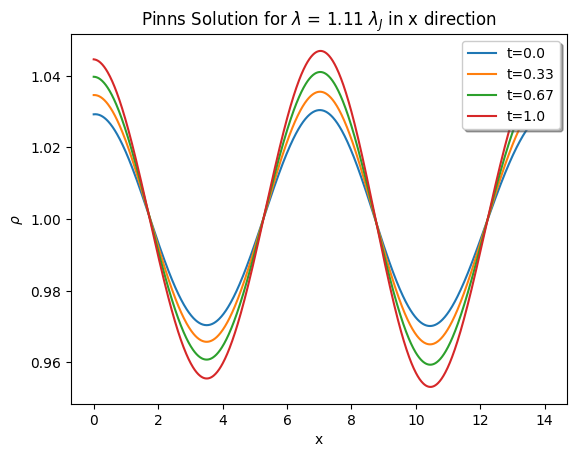

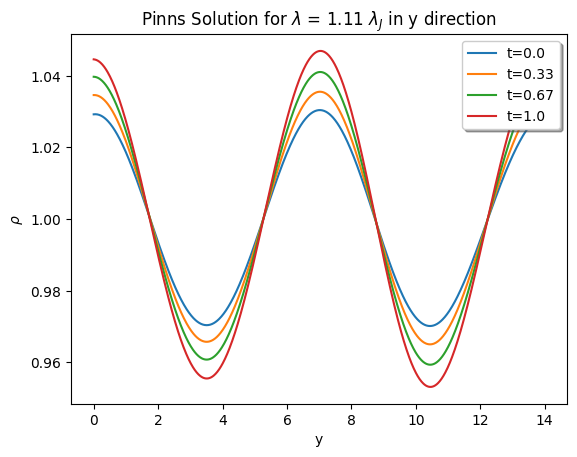

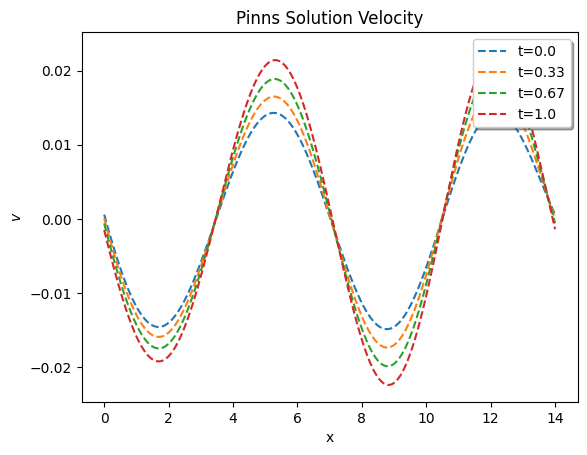

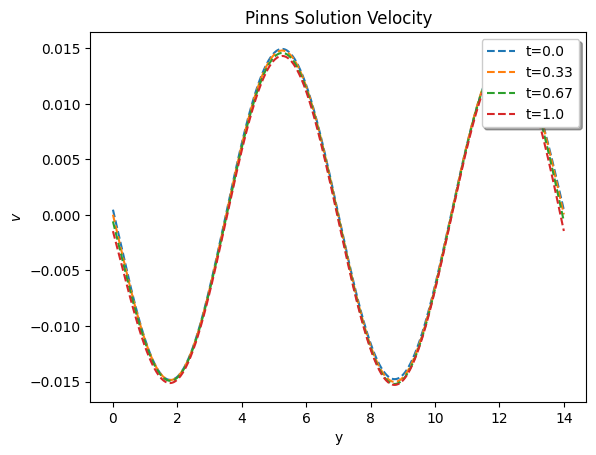

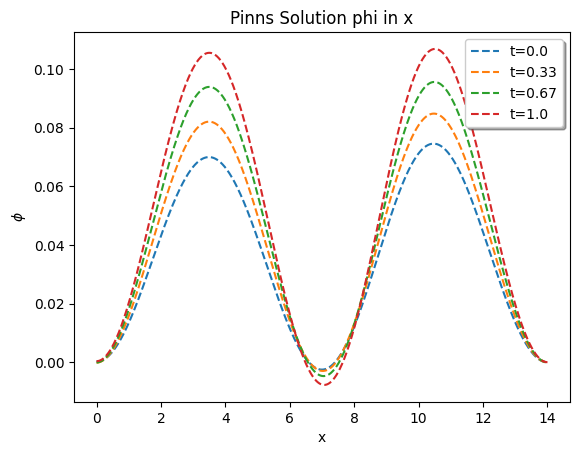

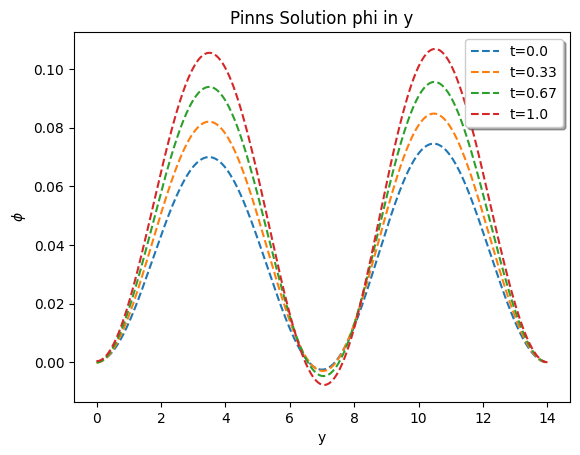

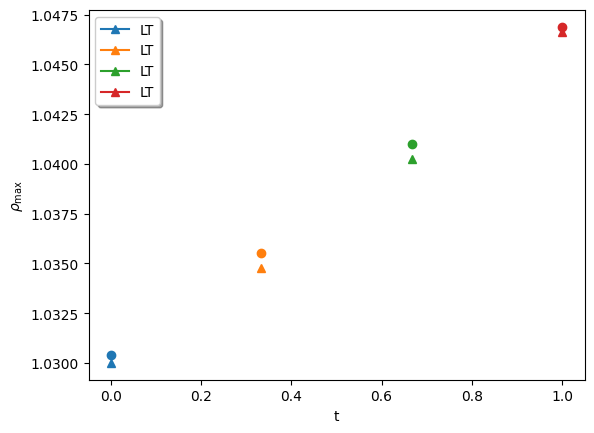

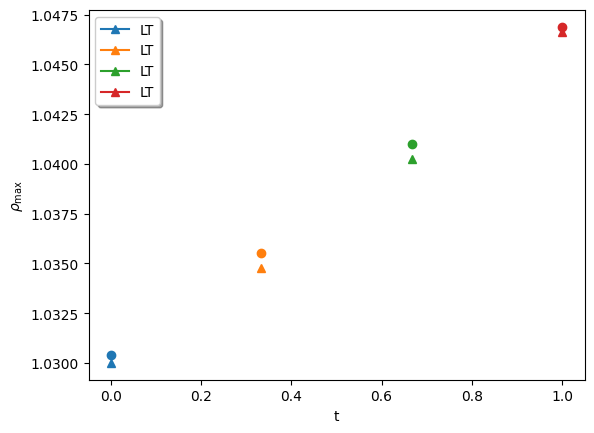

In [10]:
import plotting as pt
time_array = np.linspace(0,int(tmax),int(tmax)+3)
initial_params = xmin,xmax,ymin,ymax,rho_1, alpha ,lam ,output_folder,tmax ## required for plotting
pt.plot_function(net,time_array,initial_params,velocity=True,isplot =True)